In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np
import scipy as sp
from scipy.stats import linregress
from sklearn.covariance import MinCovDet
import copy
from math import sqrt
%matplotlib inline

# Data-set

In [2]:
df = pd.read_csv("../data_set/pokemon_alopez247.csv")
df = df[["Name", "Height_m", "Weight_kg"]]
df

,Name,Height_m,Weight_kg
0,Bulbasaur,0.71,6.9
1,Ivysaur,0.99,13.0
2,Venusaur,2.01,100.0
3,Charmander,0.61,8.5
4,Charmeleon,1.09,19.0
...,...,...,...
716,Yveltal,5.79,203.0
717,Zygarde,5.00,305.0
718,Diancie,0.71,8.8
719,Hoopa,0.51,9.0


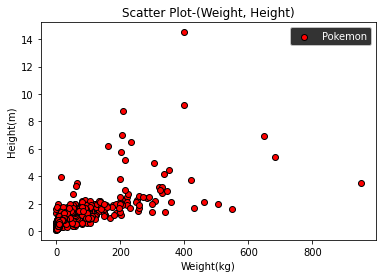

In [3]:
red_dot2 = plt.scatter(x=df["Weight_kg"], y=df["Height_m"], color="red", edgecolors="black")
plt.xlabel("Weight(kg)")
plt.ylabel("Height(m)")
plt.title("Scatter Plot-(Weight, Height)")
red_patch = mpatches.Patch(color="red", label="Pokemon")
legend = plt.legend([red_dot2], ["Pokemon"], loc="upper right", facecolor="black")
[text.set_color("white") for text in legend.get_texts()]
plt.show()

# Detecting Outlier
---
* **Detecting multivariate outliers**
* **Robust Mahalanobis Distance**
> The Minimum Covariance Determinant method (MCD) provides robust estimates for µ and C by only using a subset of the sample. It only uses the observations where the determinant of the covariance matrix is as small as possible. It is defined as the classic MD but with robust estimates for mean and covariance:

In [9]:
def robust_mahalanobis_method(df):
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))#degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

In [24]:
df_bivariate = df[["Weight_kg", "Height_m"]]
outliers, md = robust_mahalanobis_method(df=df_bivariate)
df_copy = copy.deepcopy(df_bivariate)
df_copy["md"] = md

def flag_outlier(df, outliers):
    flag = []
    for index in range(df.shape[0]):
        if index in outliers:
            flag.append(1)
        else:
            flag.append(0)
    return flag

df_copy["flag"] = flag_outlier(df_bivariate, outliers)

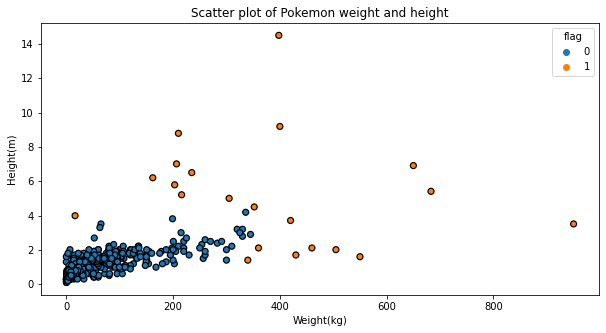

In [55]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
ax = sns.scatterplot(x="Weight_kg", y="Height_m", hue="flag", data=df_copy, edgecolor="black", linewidth=1.2)
ax.set(title="Scatter plot of Pokemon weight and height", xlabel="Weight(kg)", ylabel="Height(m)")
plt.show()

In [68]:
df_all = df[["Weight_kg", "Height_m"]]
df_non_outlier = df[df_copy["flag"] == 0]

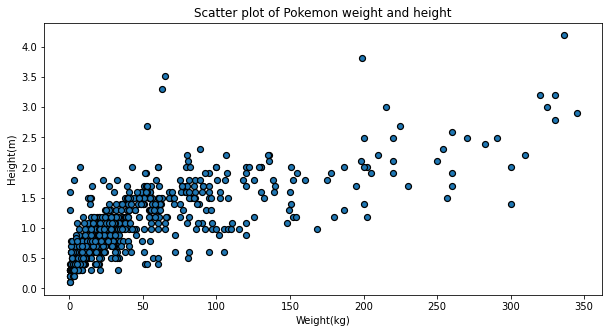

In [70]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
ax = sns.scatterplot(x="Weight_kg", y="Height_m", data=df_non_outlier, edgecolor="black", linewidth=1.2)
ax.set(title="Scatter plot of Pokemon weight and height", xlabel="Weight(kg)", ylabel="Height(m)")

plt.show()

# Linear Regression
---

In [116]:
x = df_non_outlier["Weight_kg"]
y = df_non_outlier["Height_m"]
n = x.size
x_bar = x.mean()
y_bar = y.mean()
Sxx = np.sum(x*x) - n * x_bar**2
Syy = np.sum(y*y) - n * y_bar**2
Sxy = np.sum(x*y) - n * x_bar * y_bar
r = Sxy / (sqrt(Sxx) * sqrt(Syy))
r

0.7512231293702626

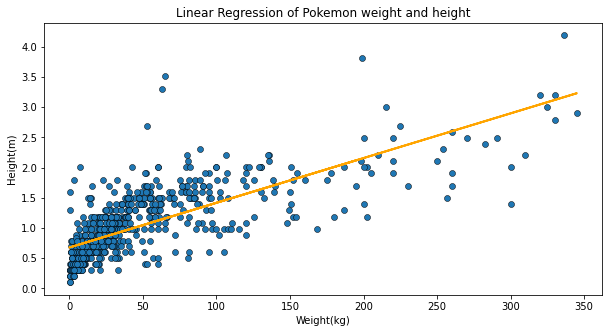

slope(m): 0.007401677999523718
y-intercept(b): 0.6785728352726581
Linear Correlation(r): 0.7512231293702626


In [151]:
x=df_non_outlier["Weight_kg"]
y=df_non_outlier["Height_m"]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
ax = sns.scatterplot(x="Weight_kg", y="Height_m", data=df_non_outlier, edgecolor="black")
ax.set(title="Linear Regression of Pokemon weight and height", xlabel="Weight(kg)", ylabel="Height(m)")

m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x + b,linewidth=2,color='orange')

plt.show()

print('slope(m):',m)
print('y-intercept(b):',b)
print('Linear Correlation(r):',r)


# บทวิเคราะห์ Linear Regression
---
    1.จากค่า Linear Correlation(r) ทำให้เห็นว่าน้ำหนักของ Pokemon มีอิทธิพลต่อส่วนสูงของ Pokemon มาก (Strong)
    2.จากค่า slope(m) ทำให้รู้ว่าน้ำหนักของ Pokemon แปรผันตรงกับส่วนสูงของ Pokemon เชน เมื่อน้ำหนักของ Pokemon สูงขึ้นส่วนสูงของ Pokemon จะมีแนวโน้มสูงขึ้นเช่นกัน
    3.จากค่า y-intercept(b) ทำให้รู้ว่าถ้าน้ำหนักของ Pokemon เข้าใกล้ 0 กิโลกรัม จะมีส่วนสูงประมาณ 0.679 เมตร
    4.เส้น Linear Regression มีความสมเหตุสมผลในช่วงน้ำหนักของ Pokemon 0.1-345.0 กิโลกรัมเท่านั้น
    5.การนำ outlier ออกก่อนนำมาทำ Linear Regression โดยวิธี Robust Mahalanobis Distance ทำให้ความแปรปรวนในข้อมูลน้อยลง ทำให้ได้ผลลัพธ์ที่มีนัยสำคัญทางสถิติมากขึ้น

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ad0c918b-c6e2-4a56-985c-f4267acfa022' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>